Simple quick update latest weather

In [20]:
# Tell matplotlib to plot in line
%matplotlib inline

import datetime

# import pandas
import pandas

# seaborn magically adds a layer of goodness on top of Matplotlib
# mostly this is just changing matplotlib defaults, but it does also
# provide some higher level plotting methods.
import seaborn

# Tell seaborn to set things up
seaborn.set()

def smooth(data, thresh=None):
    
    means = data.mean()

    if thresh is None:
        sds = data.std()
    else:
        sds = thresh
    
    delta = data - data.shift()
    
    good = delta[abs(delta) < sds]

    #print(good.describe())
    
    return delta.where(good, 0.0)


In [21]:
infile = "../files/kittycam_weather.csv"

!scp 192.168.0.128:Adafruit_Python_BMP/weather.csv $infile

weather.csv                                   100%  669KB 669.5KB/s   00:00    


In [22]:
!wc ../files/weather.csv

  564  1127 56016 ../files/weather.csv


In [23]:
""" assume it is csv and let pandas do magic

  index_col tells it to use the 'date' column in the data
  as the row index, plotting picks up on this and uses the
  date on the x-axis

  The *parse_dates* bit just tells it to try and figure out
  the date/time in the columne labeled 'date'.
"""
data = pandas.read_csv(infile, index_col='date', parse_dates=['date'])

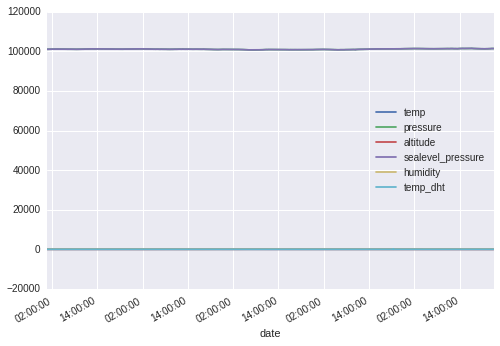

In [24]:
data.plot()

In [25]:
# smooth the data to filter out bad temps and pressures
data.altitude = (smooth(data.altitude, 5.0).cumsum() + data.altitude[0])
data.temp = (smooth(data.temp, 5.0).cumsum() + data.temp[0])

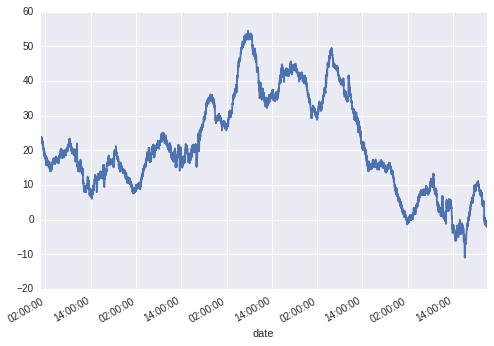

In [26]:
data.altitude.plot()

In [27]:
data.describe()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht
count,6963.000000,6963.000000,6963.000000,6963.000000,6962.000000,6962.000000
mean,27.171262,101086.724113,21.436997,101087.860836,81.107642,26.885349
std,1.663537,188.998952,14.211993,188.961939,7.108113,1.450439
min,23.900000,100672.000000,-10.957680,100678.000000,60.500000,23.700001
25%,26.000000,100923.000000,10.593998,100924.000000,76.900002,25.799999
50%,26.900000,101105.000000,18.582347,101106.000000,82.300003,26.799999
75%,28.000000,101212.000000,33.772820,101212.500000,86.099998,27.600000
max,32.300000,101518.000000,54.507673,101518.000000,94.300003,31.000000


### Last 24 hours:

In [28]:
datetime.datetime.now()

datetime.datetime(2015, 7, 27, 20, 3, 27, 617357)

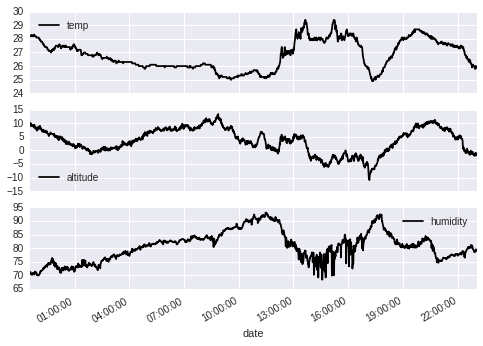

In [29]:
# reading is once a minute, so take last 24 * 60 readings
def plotem(data, n=-60):
    
    
    if n < 0:
        start = n
        end = len(data)
    else:
        start = 0
        end = n
        
    data[['temp', 'altitude', 'humidity']][n:].plot(subplots=True)
        
plotem(data, -24*60)

### Last week

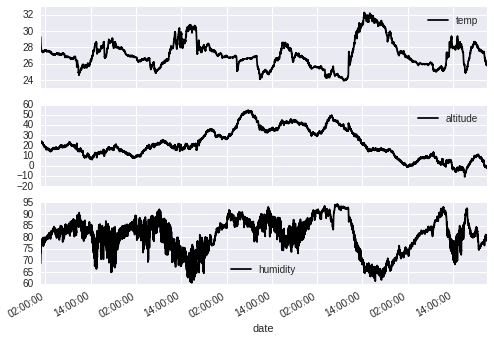

In [30]:
# reading is once a minute, so take last 7 * 24 * 60 readings
plotem(data, -7*24*60)

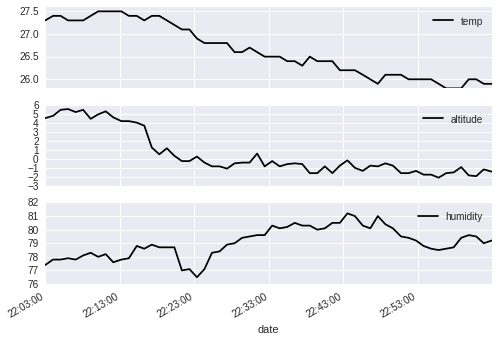

In [31]:
plotem(data)

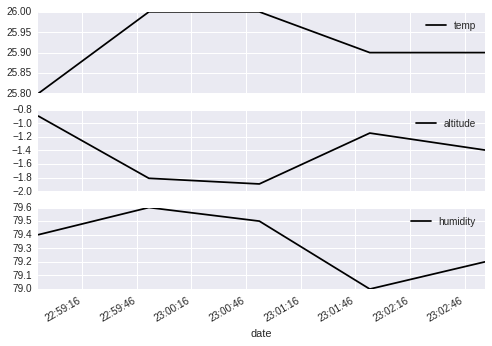

In [32]:
plotem(data, -5)

## Look at all the data

In [33]:
data.describe()

,temp,pressure,altitude,sealevel_pressure,humidity,temp_dht
count,6963.000000,6963.000000,6963.000000,6963.000000,6962.000000,6962.000000
mean,27.171262,101086.724113,21.436997,101087.860836,81.107642,26.885349
std,1.663537,188.998952,14.211993,188.961939,7.108113,1.450439
min,23.900000,100672.000000,-10.957680,100678.000000,60.500000,23.700001
25%,26.000000,100923.000000,10.593998,100924.000000,76.900002,25.799999
50%,26.900000,101105.000000,18.582347,101106.000000,82.300003,26.799999
75%,28.000000,101212.000000,33.772820,101212.500000,86.099998,27.600000
max,32.300000,101518.000000,54.507673,101518.000000,94.300003,31.000000


I currently have two temperature sensors:

* DHT22 sensor which gives temperature and humidity.
* BMP180 sensor which gives pressure and temperature.

The plot below shows the two temperature plots.

Both these sensors are currently in my study.  For temperature and humidity I would like to have some readings from outside.  If I can solder them to a phone jack then I can just run phone cable to where they need to be.

**Below** plots the current values from these sensors.  This is handy for calibration.

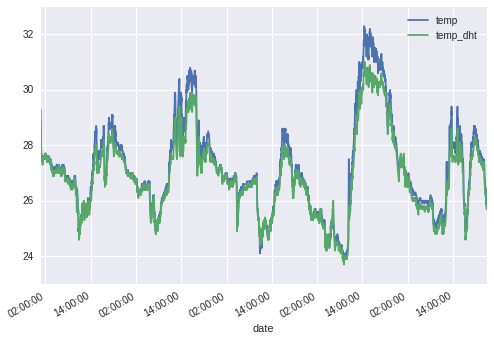

In [34]:
data[['temp', 'temp_dht']].plot()

## Dew Point

The warmer air is, the more moisture it can hold.  The *dew point* is
the temperature at which air would be totally saturated if it had as 
much moisture as it currently does. 

Given the temperature and humidity the *dew point* can be calculated, the actual formula is
pretty complex.

It is explained in more detail here: http://iridl.ldeo.columbia.edu/dochelp/QA/Basic/dewpoint.html

>If you are interested in a simpler calculation that gives an approximation of dew point temperature if you know >the observed temperature and relative humidity, the following formula was proposed in a 2005 article by Mark G. >Lawrence in the Bulletin of the American Meteorological Society:

$$Td = T - ((100 - RH)/5.)$$


In [35]:
data['dewpoint'] = data.temp - ((100. - data.humidity)/5.)

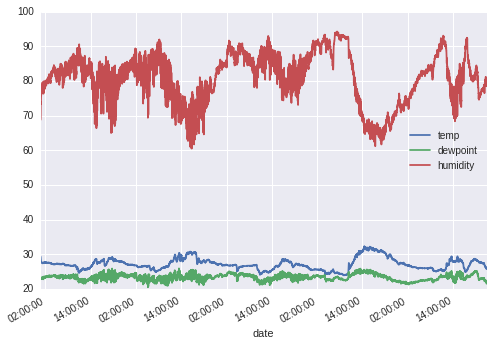

In [36]:
data[['temp', 'dewpoint', 'humidity']].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7faa6602abe0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7faa661647f0>], dtype=object)

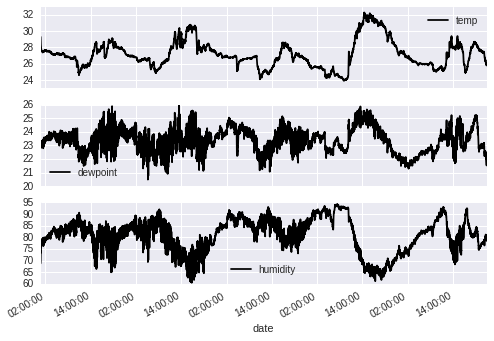

In [37]:
data[['temp', 'dewpoint', 'humidity']].plot(subplots=True)

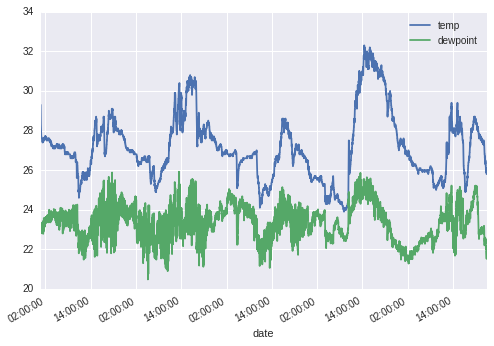

In [38]:
data[['temp', 'dewpoint']].plot()